In [5]:
import sys
path = ".."
if path not in sys.path:
    sys.path.insert(0, path)

In [6]:
from absolute_path import absolutePath
import os

corpus = "lipade_groundtruth"

os.listdir(absolutePath + 'representation/image/results/raw/' + corpus)

['resnet18_stage2.npy',
 'clip_transfer_resnet50x4.npy',
 'resnet50_stage2.npy',
 'clip_transfer_vitl14.npy',
 'resnet18_stage3.npy',
 'clip_transfer_resnet101.npy',
 'clip_transfer_resnet50x64.npy',
 'clip_transfer_resnet50x16.npy',
 'resnet50_stage4.npy',
 'clip_transfer_resnet50.npy',
 'clip_transfer_vitb32.npy',
 'resnet50_stage3.npy',
 'resnet18_stage4.npy',
 'clip_transfer_vitl14_336p.npy',
 'flava.npy',
 'clip_transfer_vitb16.npy']

In [259]:
methods = [
    ('resnet18_stage2', 'image'),
    ('resnet18_stage3', 'image'),
    ('resnet18_stage4', 'image'),
    ('resnet50_stage2', 'image'),
    ('resnet50_stage3', 'image'),
    ('resnet50_stage4', 'image'),
    ('sift_absolute', 'image'),
    ('sift_proportional', 'image'),
    ('simclr', 'image'),
    ('clip_transfer_resnet50', 'multimodal'),
    ('clip_transfer_resnet50x4', 'multimodal'),
    ('clip_transfer_resnet50x64', 'multimodal'),
    ('clip_transfer_resnet101', 'multimodal'),
    ('clip_transfer_vitb16', 'multimodal'),
    ('clip_transfer_vitb32', 'multimodal'),
    ('clip_transfer_vitl14_336p', 'multimodal'),
    ('clip_transfer_vitl14', 'multimodal'),
    ('clip_transfer_resnet50x16', 'multimodal')
]

In [ ]:
import numpy as np
from data_retrieval import lipade_groundtruth
from clustering import getPredictionFromThreshold
import evaluators
import csv

method, type = methods[-1]

distancePath = "../representation/" + type + "/results/distance/" + corpus + "/" + method + ".npy"
distance = np.load(distancePath)

In [ ]:
_,_,y = lipade_groundtruth.getDataset(mode="similar")

In [ ]:
thresholds_precision = 1000
thresholds = np.linspace(0, 1, thresholds_precision) # ((0.95, 1) for sift-absolute)

precisions, recalls, f1s = evaluators.p_r_f1_byThresholds(thresholds, distance, y)

Thresholds: 100%|██████████| 1000/1000 [00:11<00:00, 87.00it/s]


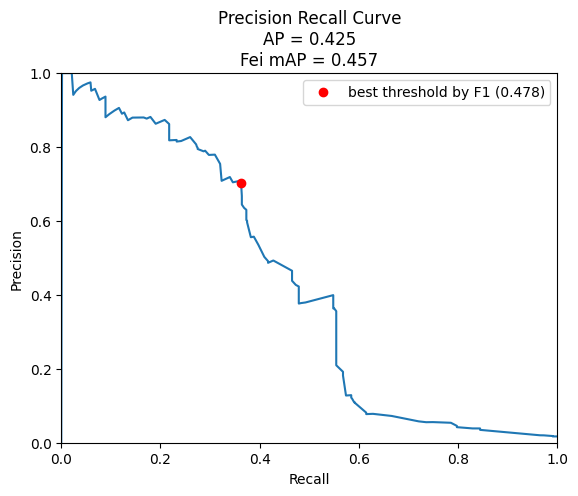

In [ ]:
AP, bestThresholdIndex = evaluators.pr_curve(precisions, recalls, f1s, other=("Fei mAP", evaluators.fei_mAP(y, distance)), save="evaluation/" + corpus + "/" + method + ".png")

In [ ]:
thresholdsClass = np.linspace(0, 1, int(thresholds_precision / 10)) # ((0.95, 1) for sift-absolute)
precisions_per_class, recalls_per_class = evaluators.p_r_class_byThresholds(thresholdsClass, distance, y)

Thresholds: 100%|██████████| 100/100 [00:05<00:00, 18.48it/s]


In [ ]:
with open('evaluation/' + corpus + '/f1.csv', mode='r') as infile:
    reader = csv.reader(infile)
    f1_dict = {(rows[0], rows[1]): rows[2] for rows in reader}

with open('evaluation/' + corpus + '/map_a.csv', mode='r') as infile:
    reader = csv.reader(infile)
    map_dict = {rows[0]:rows[1] for rows in reader}

f1_dict[(method, 'best_threshold')] = "{:.3f}".format(np.max(f1s))
map_dict[method] = "{:.3f}".format(evaluators.goncalves_mAP(precisions_per_class, recalls_per_class))

In [ ]:
with open('evaluation/' + corpus + '/f1.csv', mode='w') as outfile:
    res_dict = csv.writer(outfile)
    for key, value in f1_dict.items():
        res_dict.writerow(list(key) + [value])

with open('evaluation/' + corpus + '/map_a.csv', mode='w') as outfile:
    res_dict = csv.writer(outfile)
    res_dict.writerows(map_dict.items())

In [ ]:
bestPredictedY = getPredictionFromThreshold(thresholds[bestThresholdIndex], distance)
np.save("clusters/" + corpus + "/" + method + ".npy", bestPredictedY)